In [92]:
# BSNIP

import pickle
import re
import numpy as np

basis_file = '/home/anton/Documents/Tulane/Research/BSNIP/AngleBasisLong20.pkl'
demodir = '/home/anton/Documents/Tulane/Research/ImageNomer/data/anton/cohorts/BSNIP/'

basis = pickle.load(open(basis_file, 'rb'))

thetas = []
jitter = []
age = []
sex = []
race = []
sz = []
fc = []

demo = pickle.load(open(f'{demodir}/demographics.pkl', 'rb'))

for subtask in basis:
    m = re.search('([^-]+)', subtask)
    sub = m.group(1)
    a = demo['Age_cal'][sub]
    s = demo['sex'][sub] == 's1.0'
    r = demo['Race'][sub] == 'AA'
    z = demo['DXGROUP_2'][sub] == 'SZP'
#     if demo['DXGROUP_2'][sub] not in ['SZP', 'NC']:
#         continue
    age.append(a)
    sz.append(z)
    sex.append(s)
    race.append(r)
    thetas.append(basis[subtask]['thetas'])
    jitter.append(basis[subtask]['jitter'])
    p = np.load(f'{demodir}/fc/{sub}_task-unk_fc.npy')
    fc.append(p)
    
thetas = np.stack(thetas)
jitter = np.stack(jitter)
age = np.array(age).astype('int')
sex = np.array(sex).astype('int')
race = np.array(race).astype('int')
sz = np.array(sz).astype('int')
fc = np.stack(fc)

print([a.shape for a in [thetas, jitter, sex, race, sz, age, fc]])
print(np.mean(1-sex))
print(np.mean(1-race))
print(np.mean(1-sz))
print(np.mean(age))

[(1244, 20, 264), (1244, 20, 264), (1244,), (1244,), (1244,), (1244,), (1244, 34716)]
0.5763665594855305
0.6889067524115756
0.840032154340836
38.209807073954984


Done eigs
Done 20
Done 15
Done 10
Done 5
Done 3
Done 1


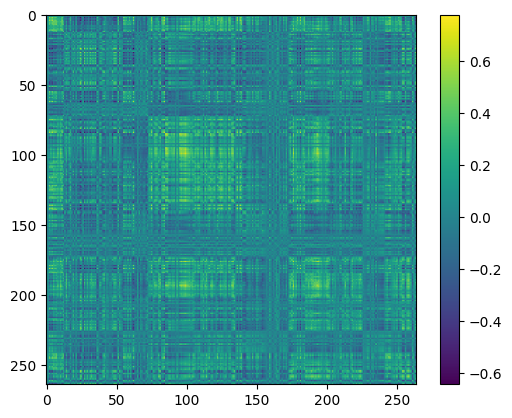

In [93]:
import matplotlib.pyplot as plt

a,b = np.triu_indices(264,1)
X = np.ones((fc.shape[0],264,264))
X[:,a,b] = fc
X[:,b,a] = fc
w, v = np.linalg.eig(X)
print('Done eigs')

w[:,20:] = 0
aps20 = np.real(np.einsum('nab,nb,ncb->nac',v,w,v))
print('Done 20')

w[:,15:] = 0
aps15 = np.real(np.einsum('nab,nb,ncb->nac',v,w,v))
print('Done 15')

w[:,10:] = 0
aps10 = np.real(np.einsum('nab,nb,ncb->nac',v,w,v))
print('Done 10')

w[:,5:] = 0
aps5 = np.real(np.einsum('nab,nb,ncb->nac',v,w,v))
print('Done 5')

w[:,3:] = 0
aps3 = np.real(np.einsum('nab,nb,ncb->nac',v,w,v))
print('Done 3')

w[:,1:] = 0
aps1 = np.real(np.einsum('nab,nb,ncb->nac',v,w,v))
print('Done 1')

plt.imshow(aps3[1])
plt.colorbar()
plt.show()

In [94]:
def mat2vec(mat):
    a,b = np.triu_indices(264,1)
    return mat[:,a,b]

aps20 = mat2vec(aps20)
aps15 = mat2vec(aps15)
aps10 = mat2vec(aps10)
aps5 = mat2vec(aps5)
aps3 = mat2vec(aps3)
aps1 = mat2vec(aps1)

print('Done')

Done


In [106]:
def rmse(yhat, y):
    if isinstance(yhat, np.ndarray) or isinstance(yhat, int):
        f = np.mean
    else:
        f = torch.mean
    return f((y-yhat)**2)**0.5

def tops(thetas, jitter):
    t0 = np.expand_dims(thetas, 2)
    t1 = np.expand_dims(thetas, 3)
    j0 = np.expand_dims(jitter, 2)
    j1 = np.expand_dims(jitter, 3)
    ps = np.cos(t0-t1)*(j0*j1)
    a,b = np.triu_indices(264, 1)
    ps = ps[:,:,a,b]
    return ps
    
ps = tops(thetas, jitter)
aps = np.mean(ps, axis=1)
res = fc - aps

print(ps.shape)
print(aps.shape)
print(res.shape)

(1244, 20, 34716)
(1244, 34716)
(1244, 34716)


In [107]:
aps20 = aps
res20 = res

print('Done')

Done


In [70]:
import sys

pth = '../../LatentSimilarity/'

if pth not in sys.path:
    sys.path.append(pth)
    
print(sys.path)

['/home/anton/Documents/Tulane/Research/code/AngleBasis', '/usr/lib/python310.zip', '/usr/lib/python3.10', '/usr/lib/python3.10/lib-dynload', '', '/home/anton/.local/lib/python3.10/site-packages', '/usr/lib/python3.10/site-packages', '../../LatentSimilarity/']


In [97]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from latsim import LatSimClf
import warnings
warnings.filterwarnings("ignore")

def cat(x, **kwargs):
    return np.concatenate(x, **kwargs)

def predict(xtr, xt, ytr, yt, lst):
#     reg = LogisticRegression(C=1,max_iter=100).fit(xtr, ytr) 
    reg = LatSimClf(nepochs=1000).fit(xtr, ytr) 
    yhat = reg.predict(xt)
    p = reg.predict_proba(xt)
#     acc = np.mean(yt == yhat)
    acc = roc_auc_score(yt, p[:,1])
    print(acc)
    lst.append(acc)
    return p
    
def get_res(fctr, fct, abtr, abt):
    return fctr-abtr, fct-abt

def combine(yt, p0, p1, lst):
    p = (p0+p1)/2
#     acc = np.mean(yt == np.argmax(p, axis=1))
    acc = roc_auc_score(yt, p[:,1])
    print(acc)
    lst.append(acc)

rfc = []

rab1 = []
rab3 = []
rab5 = []
rab10 = []
rab15 = []
rab20 = []

rres1 = []
rres3 = []
rres5 = []
rres10 = []
rres15 = []
rres20 = []

rens1 = []
rens3 = []
rens5 = []
rens10 = []
rens15 = []
rens20 = []

rbest = []

for i in range(10):

#     xtr, xt, ytr, yt = train_test_split(fc, sex, stratify=sex, train_size=0.8)
    
#     p1 = predict(xtr, xt, ytr, yt, rfc)
#     p2 = predict(xtr, xt, ytr, yt, rfc)
    
#     combine(yt, p1, p2, rbest)

    x0tr, x0t, x1tr, x1t, x2tr, x2t, x3tr, x3t, x4tr, x4t, x5tr, x5t, x6tr, x6t, ytr, yt = train_test_split(
        fc, aps1, aps3, aps5, aps10, aps15, aps20, sex, stratify=sex, train_size=0.8)
    
    x1atr, x1at = get_res(x0tr, x0t, x1tr, x1t)
    x2atr, x2at = get_res(x0tr, x0t, x2tr, x2t)
    x3atr, x3at = get_res(x0tr, x0t, x3tr, x3t)
    x4atr, x4at = get_res(x0tr, x0t, x4tr, x4t)
    x5atr, x5at = get_res(x0tr, x0t, x5tr, x5t)
    x6atr, x6at = get_res(x0tr, x0t, x6tr, x6t)

    predict(x0tr, x0t, ytr, yt, rfc)
    
    p1 = predict(x1tr, x1t, ytr, yt, rab1)
    p2 = predict(x2tr, x2t, ytr, yt, rab3)
    p3 = predict(x3tr, x3t, ytr, yt, rab5)
    p4 = predict(x4tr, x4t, ytr, yt, rab10)
    p5 = predict(x5tr, x5t, ytr, yt, rab15)
    p6 = predict(x6tr, x6t, ytr, yt, rab20)
    
    p1a = predict(x1atr, x1at, ytr, yt, rres1)
    p2a = predict(x2atr, x2at, ytr, yt, rres3)
    p3a = predict(x3atr, x3at, ytr, yt, rres5)
    p4a = predict(x4atr, x4at, ytr, yt, rres10)
    p5a = predict(x5atr, x5at, ytr, yt, rres15)
    p6a = predict(x6atr, x6at, ytr, yt, rres20)
    
    combine(yt, p1, p1a, rens1)
    combine(yt, p2, p2a, rens3)
    combine(yt, p3, p3a, rens5)
    combine(yt, p4, p4a, rens10)
    combine(yt, p5, p5a, rens15)
    combine(yt, p6, p6a, rens20)

    combine(yt, p6, p1a, rbest)
    
    print('---')
    
print(np.mean(rfc), np.std(rfc))
print(np.mean(rbest), np.std(rbest))

print(np.mean(rab1), np.std(rab1))
print(np.mean(rab3), np.std(rab3))
print(np.mean(rab5), np.std(rab5))
print(np.mean(rab10), np.std(rab10))
print(np.mean(rab15), np.std(rab15))
print(np.mean(rab20), np.std(rab20))

print(np.mean(rres1), np.std(rres1))
print(np.mean(rres3), np.std(rres3))
print(np.mean(rres5), np.std(rres5))
print(np.mean(rres10), np.std(rres10))
print(np.mean(rres15), np.std(rres15))
print(np.mean(rres20), np.std(rres20))

print(np.mean(rens1), np.std(rens1))
print(np.mean(rens3), np.std(rens3))
print(np.mean(rens5), np.std(rens5))
print(np.mean(rens10), np.std(rens10))
print(np.mean(rens15), np.std(rens15))
print(np.mean(rens20), np.std(rens20))

0.7497685185185184
0.582771164021164
0.69375
0.7289682539682539
0.7064153439153439
0.7110449735449735
0.7403439153439153
0.7253306878306879
0.7476190476190476
0.75489417989418
0.6986772486772487
0.5897486772486772
0.5926587301587302
0.7118386243386243
0.7789021164021164
0.7640873015873015
0.7419312169312169
0.7232804232804233
0.7301587301587302
0.7523809523809523
---
0.7636904761904761
0.5984788359788359
0.6758267195767196
0.6660714285714286
0.74130291005291
0.7139550264550265
0.7426917989417989
0.8146825396825397
0.7625661375661374
0.7773809523809525
0.6431878306878307
0.6463624338624339
0.5676587301587301
0.7686838624338624
0.7410714285714285
0.7426587301587302
0.7441137566137566
0.7194444444444444
0.7253306878306878
0.8132275132275132
---
0.6998015873015874
0.6099537037037036
0.6847883597883598
0.7417328042328042
0.7369708994708994
0.7314153439153439
0.7058201058201058
0.7503968253968253
0.752910052910053
0.70244708994709
0.6541005291005291
0.6333994708994709
0.5840608465608466
0.71